# RSA with model RDMs

In this Notebook, we will go through how to compute model RDMs and compare them with brain RDMs.

## Preparations

In [1]:
%%capture
%pip install -U neuroboros

In [2]:
import numpy as np
import neuroboros as nb
from scipy.stats import zscore
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

The Life dataset contains fMRI data (a) during watching the Life documentary and (b) during watching videos of various actions of various animals. See Nastase et al. ([2017](https://doi.org/10.1093/cercor/bhx138), [2018](https://doi.org/10.3389/fnins.2018.00316)) for more details.

While watching the animal action clips, participants either attended to the 5 taxonomic categories (primates, ungulates, birds, reptiles, and insects) or the 4 behavioral categories (eating, fighting, running, and swimming).

`subject_sets['attention']` is a subset of the participants that participated in this attention dataset.
Other participants may only have the Life documentary data.

In [3]:
dset = nb.Life()
sids = dset.subject_sets['attention']

## Constructing model RDMs

We performed a GLM based on the 20 conditions (5 animal categories × 4 actions) of the clips, for each participant and each run. These are the first 20 contrasts of the dataset.

In [4]:
print(dset.contrasts[:20])

['primate_eating', 'primate_fighting', 'primate_running', 'primate_swimming', 'ungulate_eating', 'ungulate_fighting', 'ungulate_running', 'ungulate_swimming', 'bird_eating', 'bird_fighting', 'bird_running', 'bird_swimming', 'reptile_eating', 'reptile_fighting', 'reptile_running', 'reptile_swimming', 'insect_eating', 'insect_fighting', 'insect_running', 'insect_swimming']


The dataset has other contrasts which we don't need for this tutorial.

In [5]:
print(dset.contrasts[20:])

['primate', 'ungulate', 'bird', 'reptile', 'insect', 'eating', 'fighting', 'running', 'swimming']


The 20 contrasts are ordered, so we can use the division operation and the module operation to get the taxonomic and behavioral categories.

In [6]:
arng = np.arange(20)
print(arng)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [7]:
tax_cats = arng // 4
beh_cats = arng % 4
print(tax_cats)
print(beh_cats)

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]


The double slash ensures it's integer division, which throws away the remainder. Otherwise we will have

In [8]:
print(arng / 4)

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5
 4.75]


Here we construct the model RDMs using NumPy broadcasting.

In [9]:
tax_mat = tax_cats[:, np.newaxis] != tax_cats
beh_mat = beh_cats[:, np.newaxis] != beh_cats

In [10]:
print(tax_mat.shape)
print(tax_cats[:, np.newaxis].shape, tax_cats.shape)

(20, 20)
(20, 1) (20,)


NumPy automatically add dimensions in the beginning if the number of the (tensor) dimensions doesn't match between the two arrays.

In [11]:
print(tax_cats[:, np.newaxis].ndim, tax_cats.ndim)

2 1


Therefore the syntax has the same effect as:

In [12]:
tax_mat2 = tax_cats[:, np.newaxis] != tax_cats[np.newaxis, :]

The model RDM constructed with different ways are equivalent:

In [13]:
np.testing.assert_array_equal(tax_mat, tax_mat2)

If a dimension has one element in one array and many in the other, NumPy will also automatically duplicate the array to make the number of elements match for the dimension.

In [14]:
tax_mat3 = np.tile(tax_cats[:, np.newaxis], (1, 20)) != \
    np.tile(tax_cats[np.newaxis, :], (20, 1))
np.testing.assert_array_equal(tax_mat, tax_mat3)

In [15]:
print(np.tile(tax_cats[:, np.newaxis], (1, 20)).shape,
      np.tile(tax_cats[np.newaxis, :], (20, 1)).shape)

(20, 20) (20, 20)


Each value in `tax_mat` will be 1 if the corresponding location in the two arrays have different numbers (i.e., different taxonomic categories), and 0 if the numbers are the same (i.e., the same category).

## Visualize model RDMs

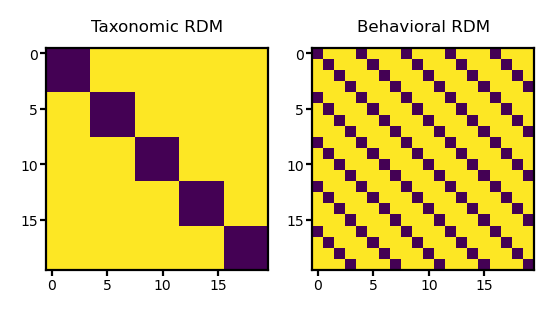

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in [8, 4]], dpi=200)
for i, (ax, mat) in enumerate(zip(axs, [tax_mat, beh_mat])):
    ax.imshow(mat)
    kind = ['Taxonomic', 'Behavioral'][i]
    ax.set_title(f'{kind} RDM', size=6)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

## Vectorize model RDMs

In [17]:
tax = squareform(tax_mat)
beh = squareform(beh_mat)
print(tax.shape, beh.shape)

(190,) (190,)


## Representational similarity analysis

With RSA, we can compare how similar two representational geometries are by computing the similarity of the vectorized RDMs.

The code below will work, but it's very slow. We'll skip running it.

```python
all_rs = {}
for task in ['tax', 'beh']:
    rs = []
    for sid in sids:
        rs_s = []
        for lr in 'lr':
            cc = []
            for run_ in [1, 2, 3, 4, 5]:
                c = dset.load_contrasts(sid, task, run_, lr, kind='beta')
                cc.append(c[:20])
            cc = np.mean(cc, axis=0)
            sls = nb.sls(lr, 20)
            for sl in sls:
                dm = cc[:, sl]
                rdm = pdist(dm, 'correlation')
                r_tax = (zscore(rdm) * zscore(tax)).mean()
                r_beh = (zscore(rdm) * zscore(beh)).mean()
                rs_s.append([r_tax, r_beh])
        rs.append(np.stack(rs_s, axis=-1))
    all_rs[task] = np.stack(rs, axis=0)
```

Here we try to perform the same computations in parallel. We define a `compute_rs` function that will compute the model similarities for each participant, which enables us to parallel across participants.

In [18]:
def compute_rs(dset, sid, task, models):
    rs = []
    for lr in 'lr':
        cc = []
        for run_ in [1, 2, 3, 4, 5]:
            c = dset.load_contrasts(sid, task, run_, lr, kind='beta')
            cc.append(c[:20])
        cc = np.mean(cc, axis=0)

        sls = nb.sls(lr, 20)
        for sl in sls:
            rdm = pdist(cc[:, sl], 'correlation')
            rr = [(zscore(rdm) * zscore(model)).mean() for model in models]
            rs.append(rr)
    rs = np.array(rs)
    return rs.T

In [19]:
all_rs = {}
for task in ['tax', 'beh']:
    jobs = [delayed(compute_rs)(dset, sid, task, [tax, beh])
            for sid in sids]
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        rs = parallel(jobs)
    rs = np.array(rs)
    all_rs[task] = rs

In this analysis, we will focus on the average model similarity across partcipants.

The attention task is congruent with the model RDM if they are the same kind (e.g., both taxonomic), and incongruent if they are different kinds (e.g., taxonomic and behavioral).

In [20]:
means = {}
for task in ['tax', 'beh']:
    for j, model in enumerate(['tax', 'beh']):
        m = all_rs[task][:, j].mean(axis=0)
        cond = 'congruent' if model == task else 'incongruent'
        means[model, cond] = m

## Visualizing RSA results

::::{grid}

:::{grid-item-card}
:columns: 6
![Taxonomic model, congruent](tax_c.png)
:::

:::{grid-item-card}
:columns: 6
![Taxonomic model, incongruent](tax_i.png)
:::

:::{grid-item-card}
:columns: 6
![Behavioral model, congruent](beh_c.png)
:::

:::{grid-item-card}
:columns: 6
![Behavioral model, incongruent](beh_i.png)
:::

::::


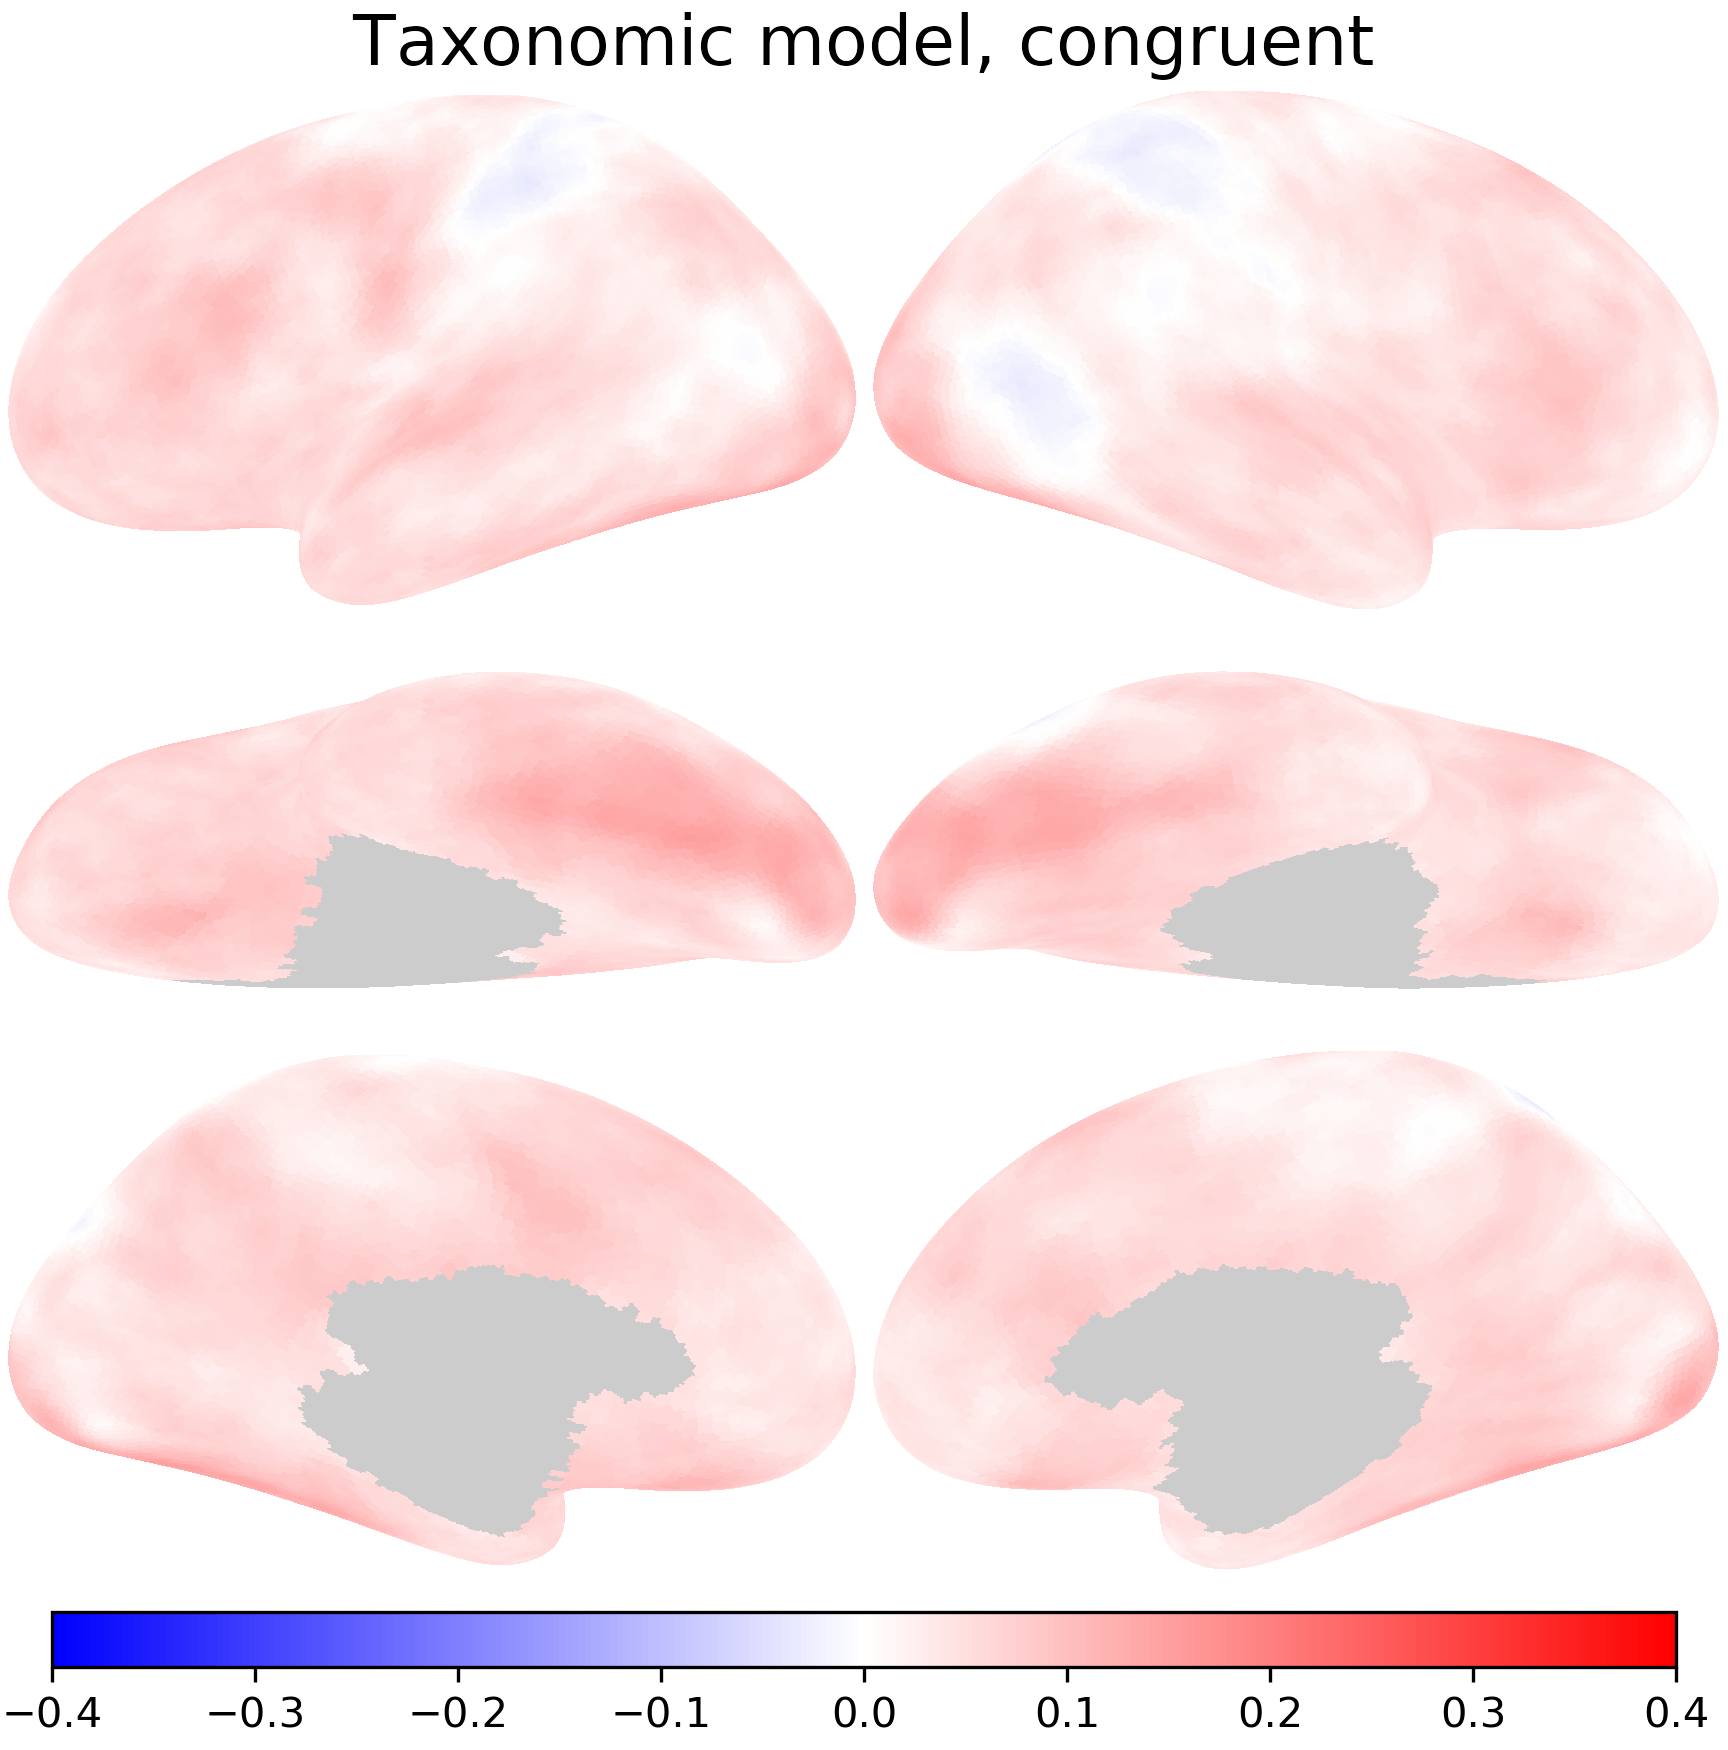

In [21]:
nb.plot(means['tax', 'congruent'], vmax=0.4, vmin=-0.4, cmap='bwr', width=500,
       title='Taxonomic model, congruent', fn='tax_c.png')

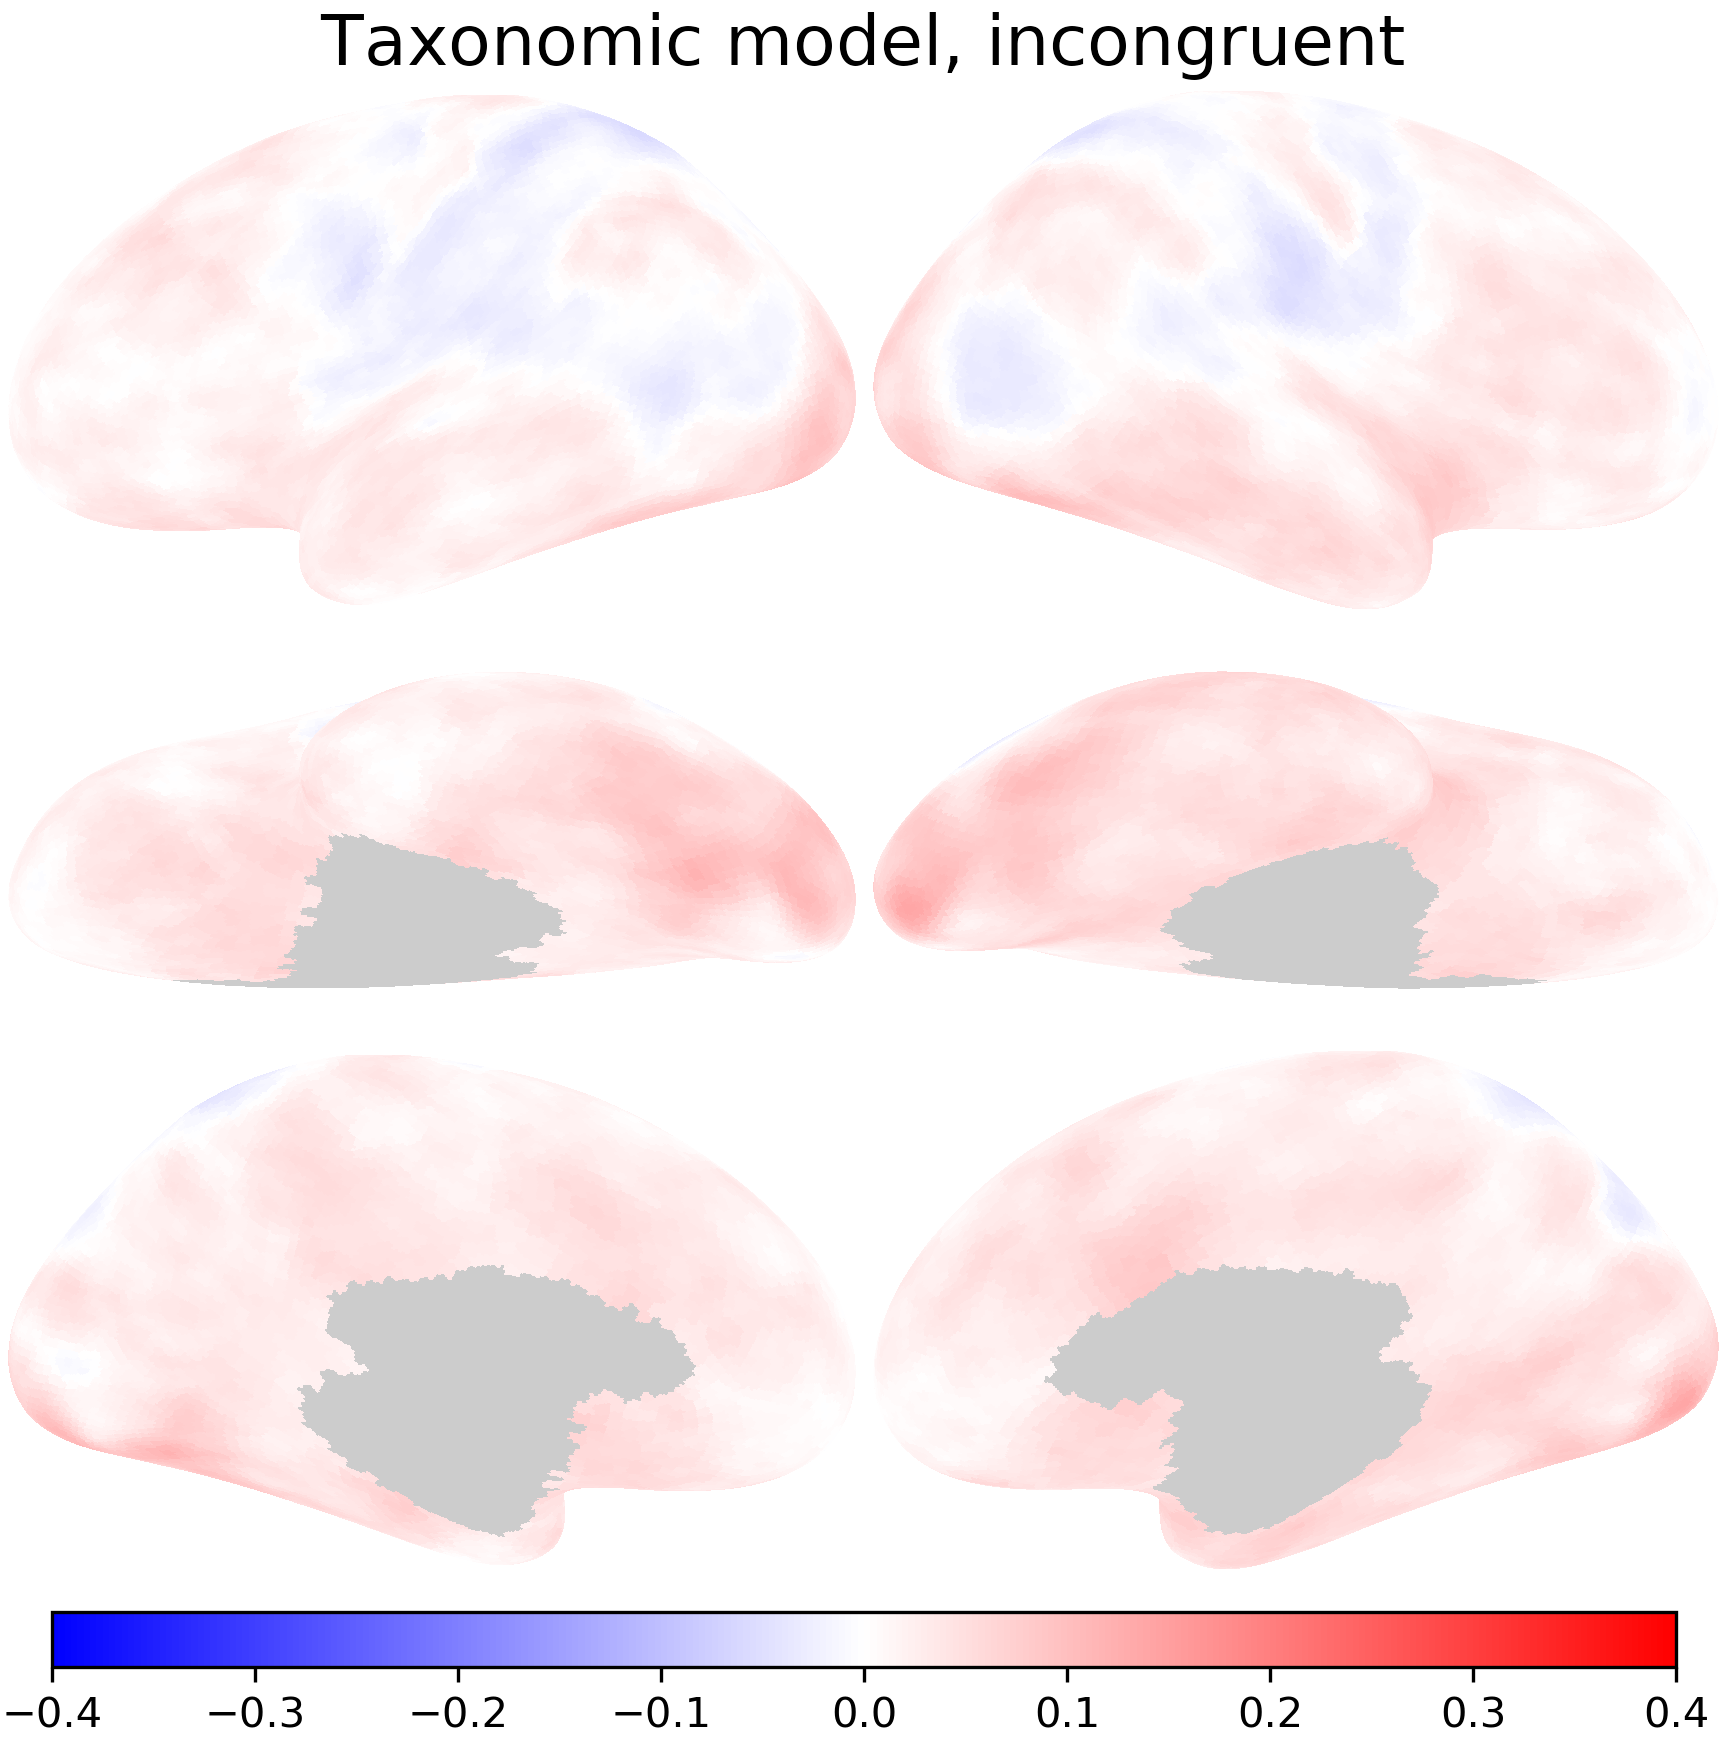

In [22]:
nb.plot(means['tax', 'incongruent'], vmax=0.4, vmin=-0.4, cmap='bwr', width=500,
       title='Taxonomic model, incongruent', fn='tax_i.png')

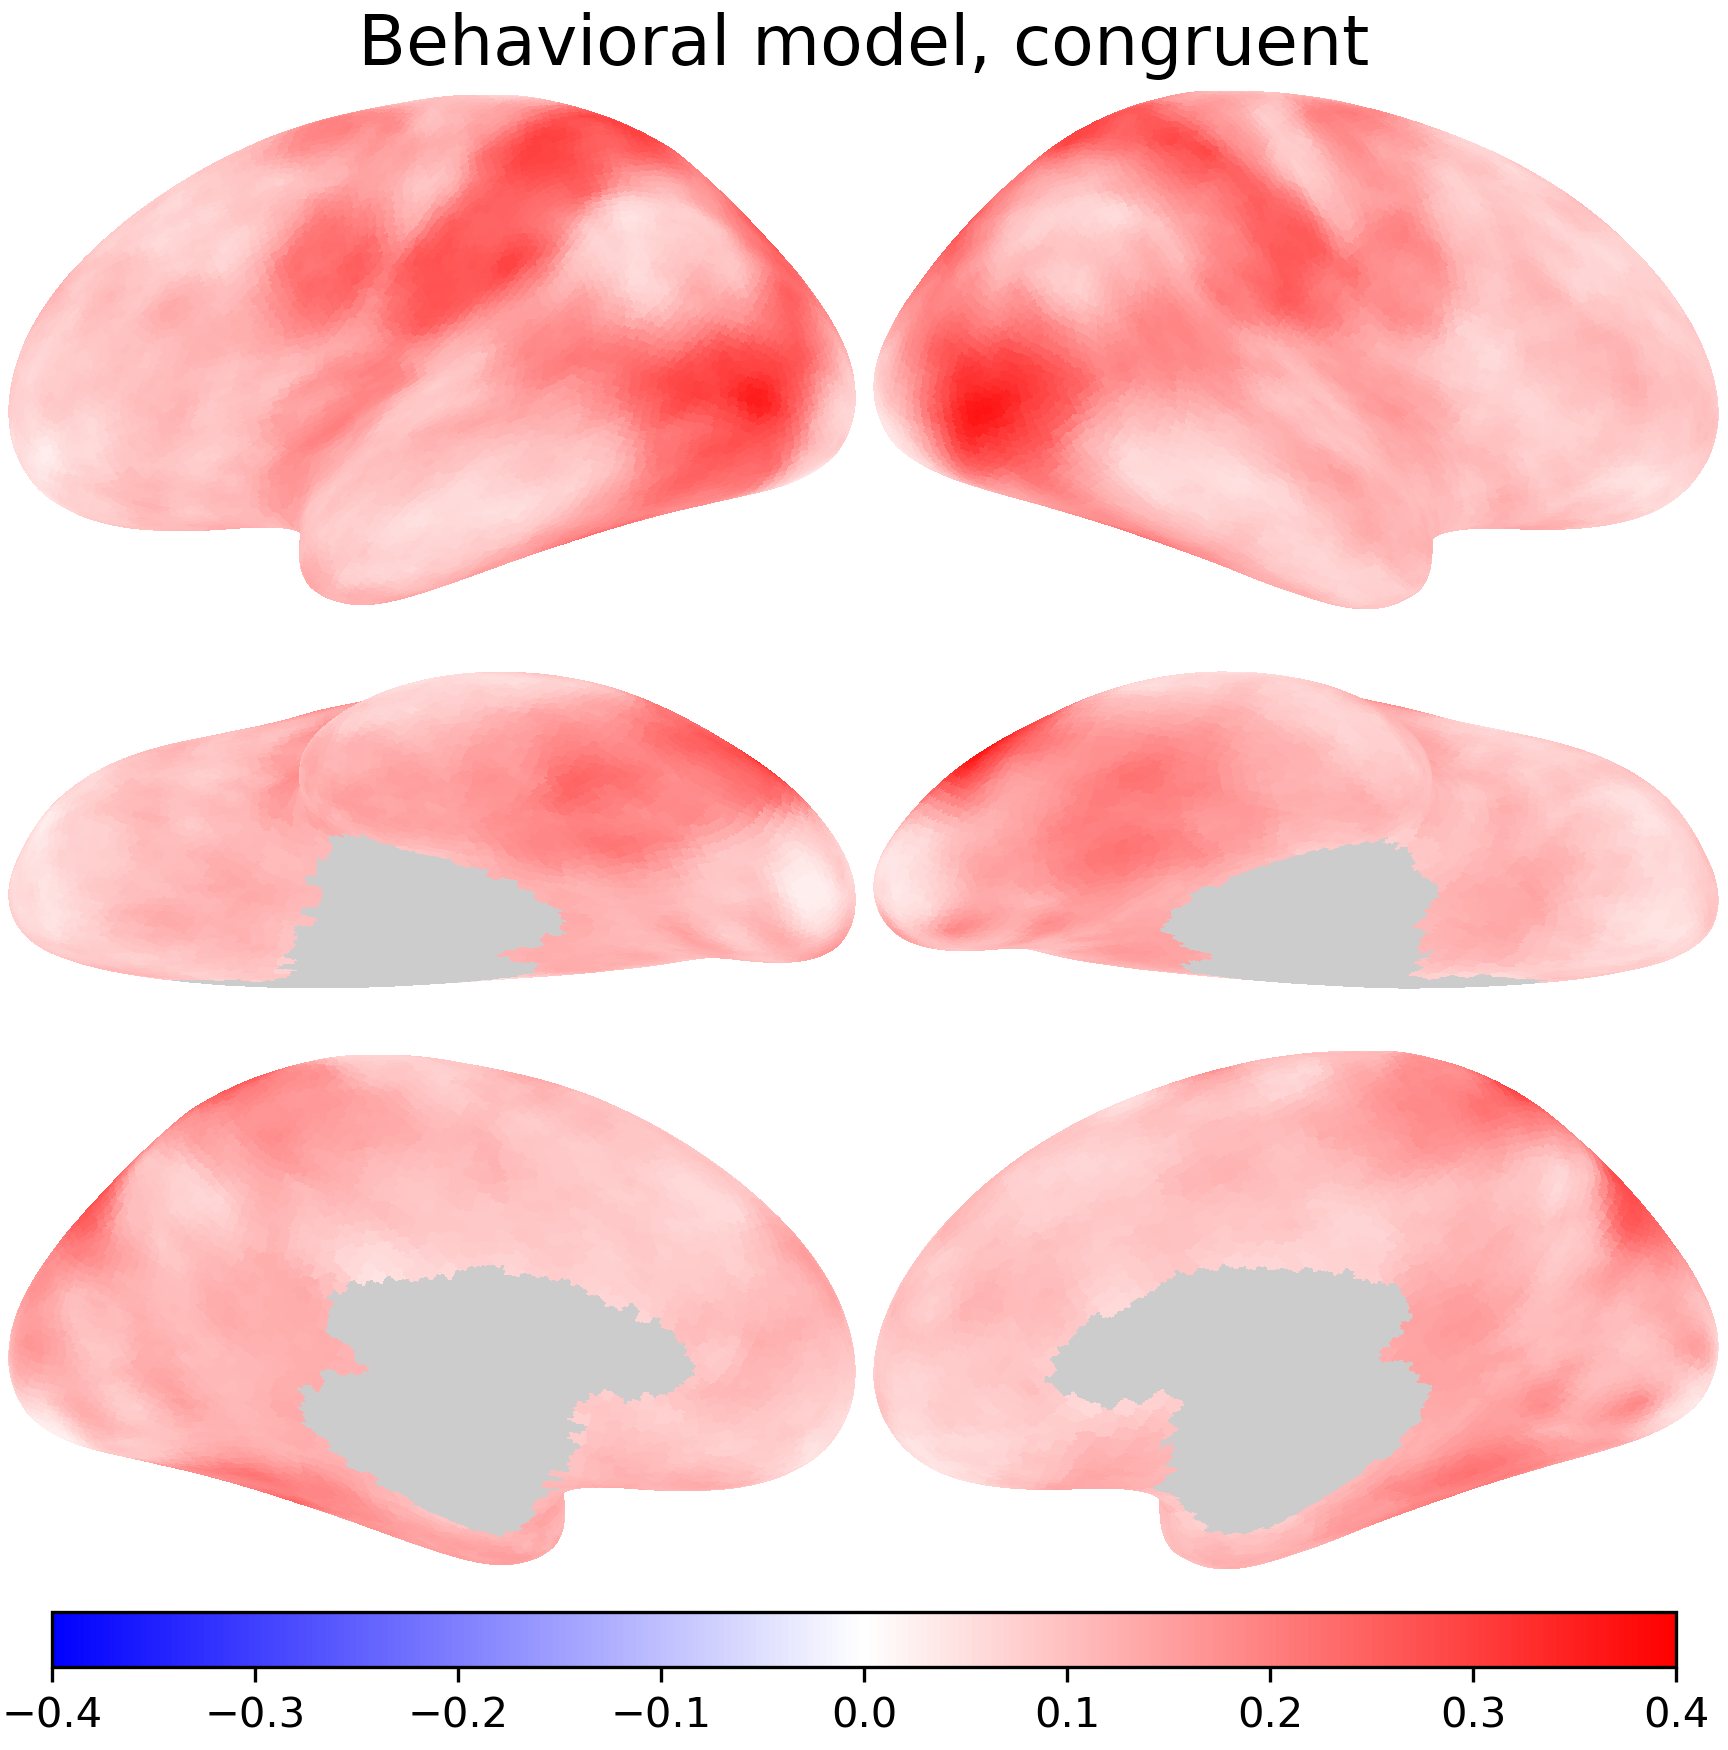

In [23]:
nb.plot(means['beh', 'congruent'], vmax=0.4, vmin=-0.4, cmap='bwr', width=500,
       title='Behavioral model, congruent', fn='beh_c.png')

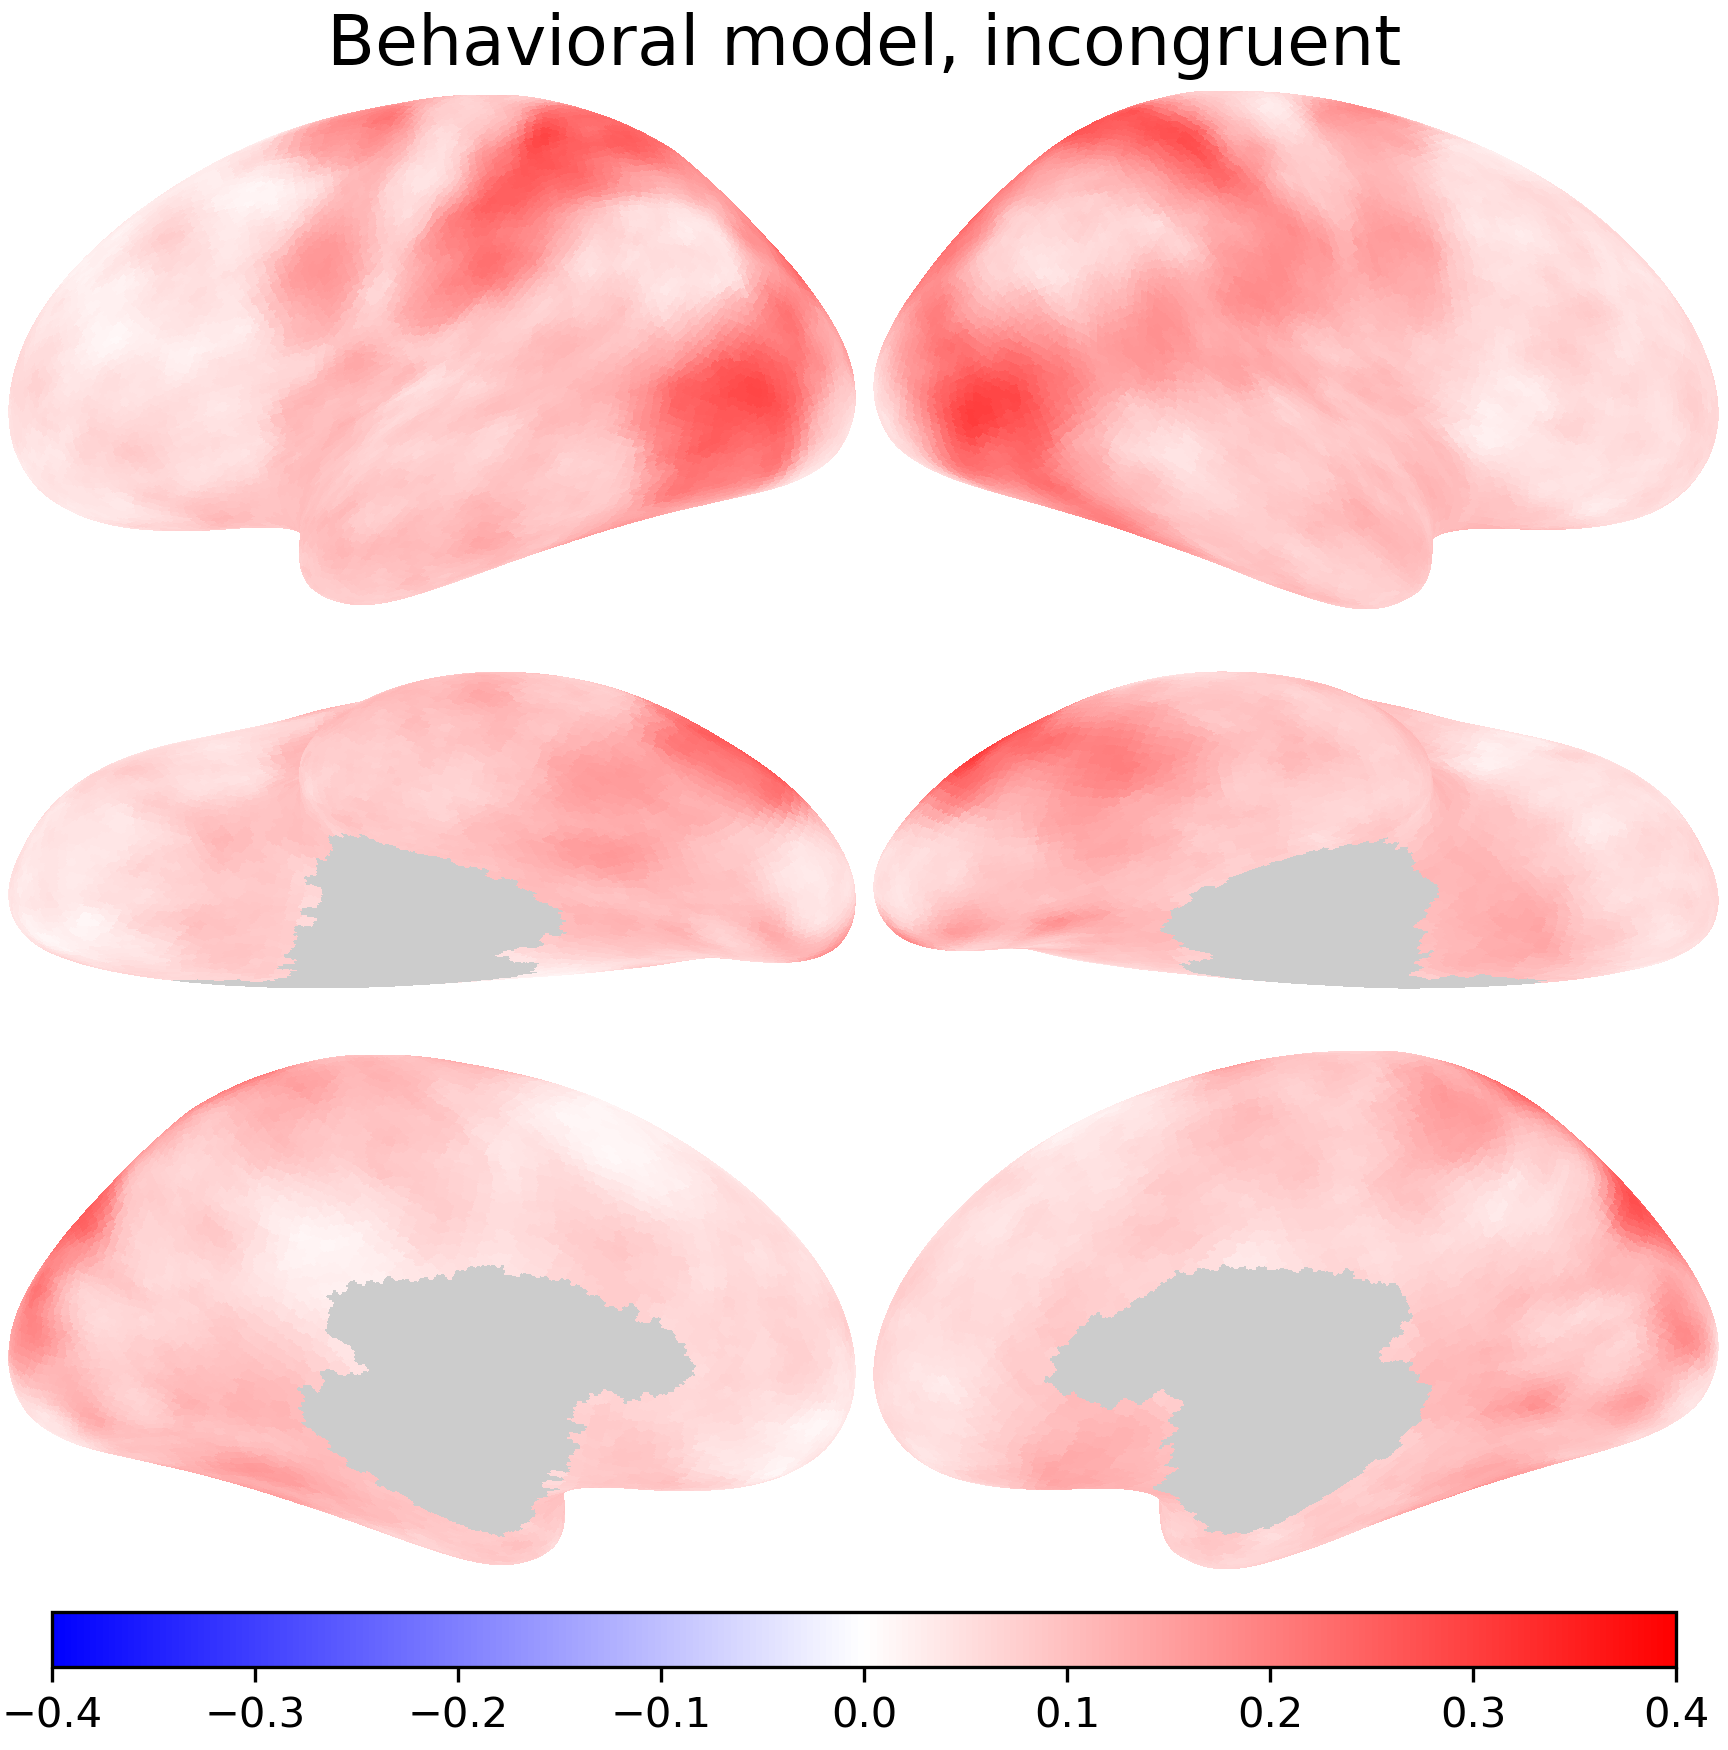

In [24]:
nb.plot(means['beh', 'incongruent'], vmax=0.4, vmin=-0.4, cmap='bwr', width=500,
       title='Behavioral model, incongruent', fn='beh_i.png')

## Exercise

In this Notebook, we use Pearson correlations everywhere for simplicity.
Depending on the type of the RDMs, there might be better ways to compute RDM similarities, such as Spearman correlation or Kendall's tau.

- Try to perform the analysis with these alternative similarity measures.
  These functions from `scipy.stats` might be helpful.
    - [scipy.stats.rankdata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html)
    - [scipy.stats.spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)
    - [scipy.stats.kendalltau](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html)

- Try to use a different searchlight radius to compute the brain RDMs (e.g., 10 mm, 15 mm).
  How does this change the results?

- Try to use the t-map instead of the beta-map for the contrasts (`kind='t'` for `dset.load_contrasts`).
  How does this change the results?